In [113]:
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.utils_numpy import nrmse
from utils.utils_vis import title_font_size, axis_font_size, ticks_font_size, width_in_inches, pk_param_units
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


Declare globals

In [ ]:
save = False
if save:
    outpath = "output/vis_report_final"
    for subfolder in ["aleatoric", "epistemic", "vivo", "appendix"]:
        if not os.path.exists(f"{outpath}/{subfolder}"):
            os.makedirs(f"{outpath}/{subfolder}")

In [115]:
pred_paths = {
    'NLLS' : 'output/vivo/nlls',
    # "SNN": "output/normal/snn_dcenet_1/predictions",
    'PINN' : 'output/vivo/pinn_ph_dcenet_4/predictions',
    # 'PINN (ens)' : 'output/vivo/pinn_ph_dcenet_ens/predictions',
    'MVE' : 'output/normal/mve_snn_dcenet_0/predictions',
    # 'MVE (ens)' : 'output/normal/mve_snn_dcenet_ens/predictions',
    # 'mve (pi)' : 'output/vivo/mve_pinn_dcenet_2/predictions',
    # 'mve (pi) (ens)' : 'output/vivo/mve_pinn_dcenet_ens/predictions',
}

Plots

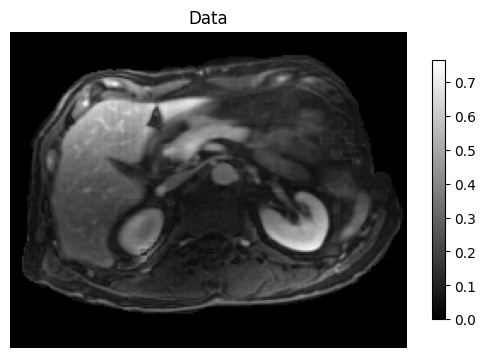

In [116]:
slice1 = np.load('data/vivo/slice1.npz')

data = slice1['data']
mask = slice1['mask']
ct = slice1['ct']
shape = ct.shape

plt.figure()
plt.imshow(data.mean(axis=-1)*mask, cmap='gray')
plt.axis('off')
plt.title('Data')
plt.colorbar(shrink=0.7)


In [117]:


preds = {name: np.load(os.path.join(path, 'test_slices.npz'), allow_pickle=True)['slice1'] for name, path in pred_paths.items()}

preds = {
    name: preds[name].item() for name in pred_paths
}
pred_params = {}
pred_params_full = {}
for name in pred_paths.keys():
    p = preds[name]["pred"]
    if len(p.shape) == 3:
        print(f"{name} reshaping params")
        p = p.reshape(-1, p.shape[-1])
    pred_params[name] = p[:,[0,2,3]].reshape(shape[:2] + (3,))
    pred_params_full[name] = p.reshape(shape[:2] + (4,))

reconstructions = {}
for name in pred_paths.keys():
    rec = preds[name]["reconstruction"]
    if len(rec.shape) == 3:
        rec = rec.reshape(-1, rec.shape[-1])
    reconstructions[name] = rec.reshape(shape[:2] + (80,))


pred_vars = {}
pred_vars_no_dt = {}
pred_errors = {}
for name in pred_paths.keys()-["SNN"]:
    pred_var = preds[name]["var"].reshape(-1,4)
    pred_vars[name] = pred_var.reshape(shape[:2] + (4,))
    pred_vars_no_dt[name] = pred_var[:,[0,2,3]].reshape(shape[:2] + (3,))
    if len(pred_var.shape) == 3:
        print(f"{name} reshaping variance")
        pred_var = pred_var.reshape(-1, pred_var.shape[-1])
    
    pred_errors[name] = np.sqrt(pred_var[:,[0,2,3]] * 2 / np.pi).reshape(shape[:2] + (3,))

# for ens in ["MVE (ens)"]:
#     ens_epi = ens + " (epi)"
#     uct_epi = preds[ens]["var_ep"][:,[0,2,3]] / preds[ens]["var_ep"][:,[0,2,3]].mean(axis=0) * preds[ens]["var"][:,[0,2,3]].mean(axis=0)
#     pred_errors[ens_epi] = np.sqrt(uct_epi * 2 / np.pi).reshape(shape[:2] + (3,))

    # pred_params[ens_epi] = pred_params[ens]
    # pred_paths[ens_epi] = pred_paths[ens]

    

In [118]:
mask = preds[list(pred_paths.keys())[-1]]["mask"]
errors = {
    name: np.abs(reconstructions[name] - ct) for name in reconstructions.keys()
}
if "MVE (ens)" in errors:
    errors["MVE (ens) (epi)"] = errors["MVE (ens)"]

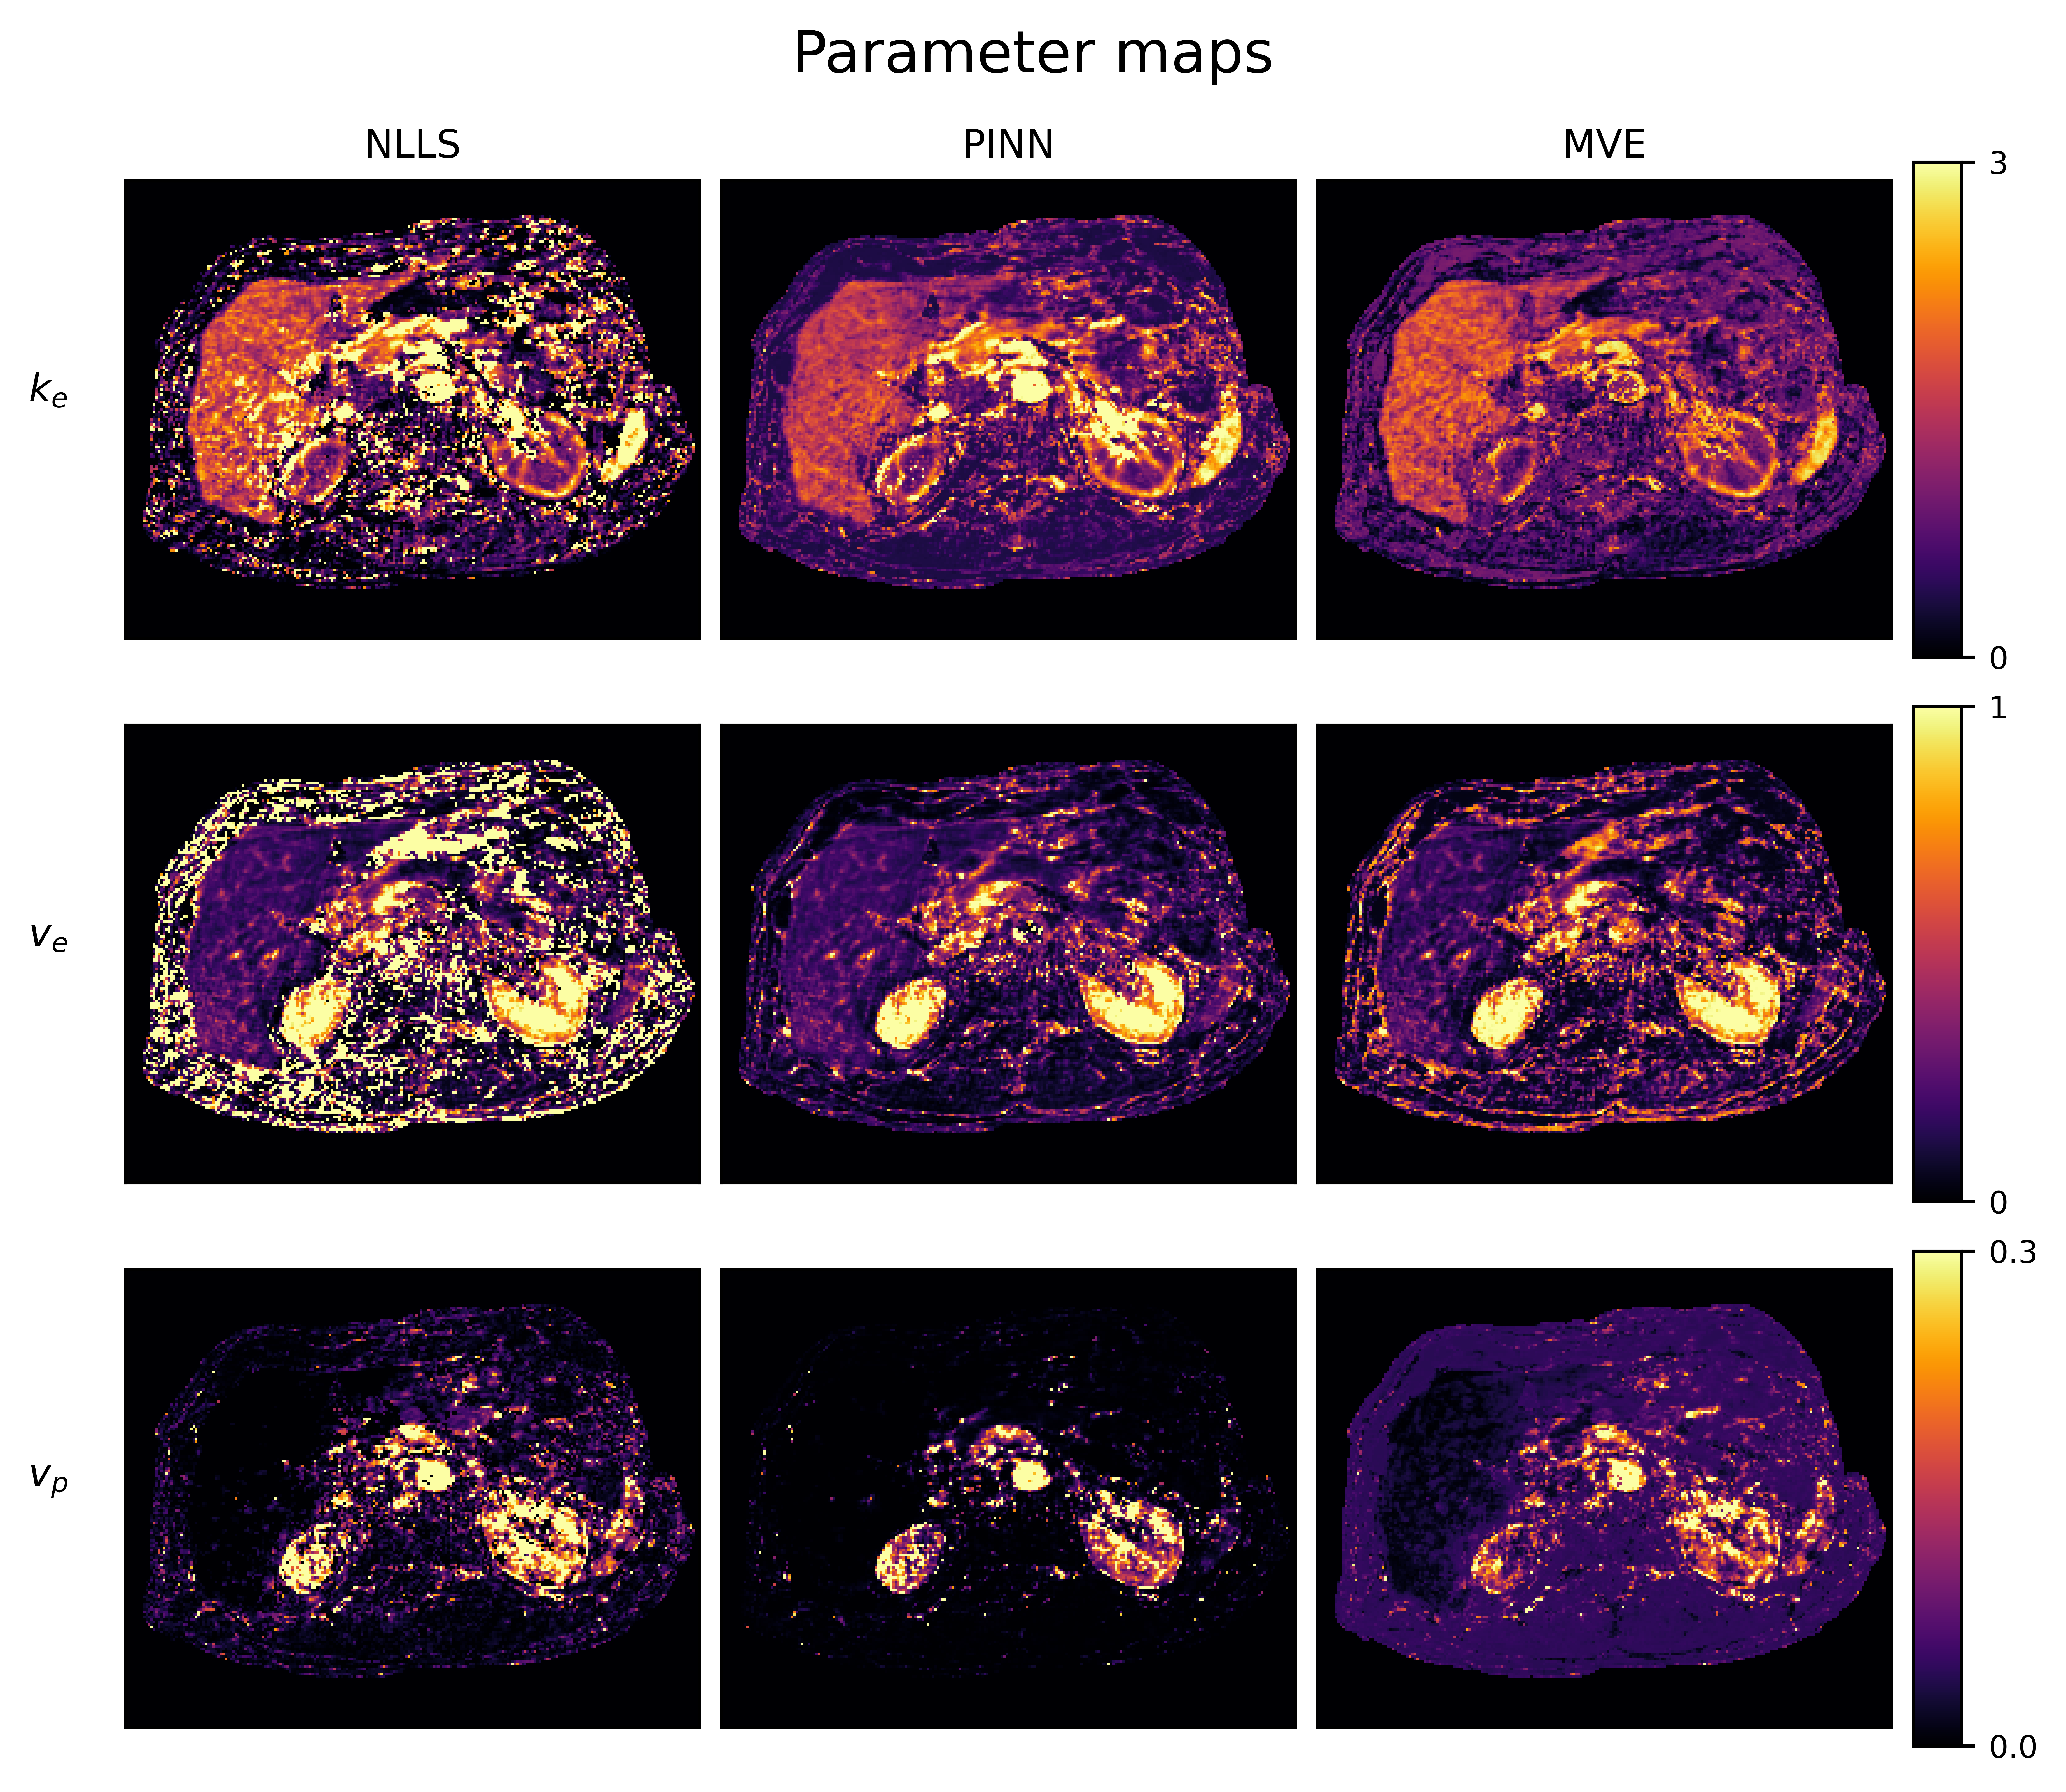

In [119]:
param_names = ["$k_e$", "$v_e$", "$v_p$"]
vmax_params = [3, 1, 0.3]
vmax_errors = np.percentile(np.stack(list(errors.values())), 99)

# Adjust grid size to fit colorbars properly
fig = plt.figure(figsize=(width_in_inches, width_in_inches*2.6/len(pred_params)), dpi=1000)

# Define a gridspec with extra space for shared colorbars
gs = GridSpec(len(param_names), len(pred_params)+1, width_ratios=[1.2]*len(pred_paths) + [0.1])#, height_ratios=[1]*(len(param_names)+1))
# fig.set_size_inches(width_in_inches * 5 + 2, width_in_inches * 4)

axs = []
for i, (name, slice) in enumerate(pred_params.items()):
    col_axes = []
    final_ims = []
    assert slice.shape[-1] == 3
    for j, param in enumerate(param_names):
        ax = fig.add_subplot(gs[j, i])
        col_axes.append(ax)
        im = ax.imshow(slice[:,:,j]*mask, cmap='inferno', interpolation='None', vmin=0, vmax=vmax_params[j])
        if j == 0:
            ax.set_title(name, fontsize=axis_font_size)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_ylabel(param, rotation=0, labelpad=20, fontsize=axis_font_size)
        if i == len(pred_paths)-1:
            cbar_ax = fig.add_subplot(gs[j, -1])
            cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.01, shrink=0.4, ticks=[0, vmax_params[j]])
            cb.ax.tick_params(labelsize=ticks_font_size)
    axs.append(col_axes)

    # # Add error plot
    # ax_error = fig.add_subplot(gs[len(param_names), i])
    # col_axes.append(ax_error)
    # im_error = ax_error.imshow(errors[name].mean(axis=-1)*mask, cmap='inferno', interpolation='None', vmax=vmax_errors)
    # ax_error.set_xticks([])
    # ax_error.set_yticks([])
    # if i == 0:
    #     ax_error.set_ylabel("Error", rotation=0, labelpad=20, fontsize=axis_font_size)
    # axs.append(col_axes)


# Add shared colorbar for the error
# cbar_ax_error = fig.add_subplot(gs[len(param_names), -1])
# cb = fig.colorbar(im_error, cax=cbar_ax_error, orientation='vertical', fraction=0.01, shrink=0.3, ticks=[0, np.floor(vmax_errors)])
# cb.ax.tick_params(labelsize=ticks_font_size)

fig.suptitle('Parameter maps', fontsize=title_font_size)


plt.tight_layout()
# set vpad subplots to 0
plt.subplots_adjust(wspace=0.05, hspace=0.1)
if save:
    plt.savefig(f"{outpath}/vivo/params.jpg", dpi=1000, bbox_inches='tight', format='jpg')

plt.show()


In [111]:
print("Amount of outliers per method")
param_names = ["$k_e$", "$v_e$", "$v_p$"]
outliers = {
    name: (np.sqrt(pred_vars_no_dt[name]) > [3,1,1]) for name in pred_errors.keys()
}
for name, ol in outliers.items():
    print(f"{name} {ol.sum()}")


Amount of outliers per method
MVE 0
PINN 1307
NLLS 20605


In [112]:

# Define grid layout
order = ["NLLS", "PINN", "MVE"]#, "MVE (ens) (epi)"]
fig = plt.figure(figsize=(width_in_inches, width_in_inches*10/9), dpi=1000)
gs = GridSpec(len(param_names) + 1, len(order) + 1, width_ratios=[1] * len(order) + [0.05])
vmaxes = {}

# Iterate over models and parameters
for j, param_name in enumerate(param_names):
    im_list = []  # Collect images for a shared colorbar per row
    masked_data = []  # Collect masked data for percentile calculation

    for i, name in enumerate(order):
        slice_data = np.sqrt(pred_vars_no_dt[name]*2/np.pi)
        assert slice_data.shape[-1] == 3
        ol = (outliers[name][:, :, j] == 0)  # Mask for outliers
        masked_slice = slice_data[:, :, j] * ol  # Apply mask
        masked_data.append(masked_slice[masked_slice > 0])  # Collect non-zero values
    
    # Concatenate masked data across all models for the row
    row_data = np.concatenate(masked_data)
    vmax_row = np.percentile(row_data, 99)  # Calculate 95th percentile after masking
    # f = np.sqrt(2/np.pi)
    vmaxes[param_name] = [0.5, 0.10, 0.04][j]#vmax_row
    # vmaxes[param_name] = [3.0, 2.0, 1.0][j]

    for i, name in enumerate(order):
        slice_data = np.sqrt(pred_vars_no_dt[name]*2/np.pi)
        assert slice_data.shape[-1] == 3
        assert outliers[name].shape[-1] == 3
        ol = (outliers[name][:, :, j] == 0)
        ax = fig.add_subplot(gs[j, i])
        pred_error = slice_data[:, :, j] * mask
        im = ax.imshow(pred_error, cmap='inferno', interpolation='none', vmax=vmaxes[param_name])
        im_list.append(im)
        # if name in ["NLLS", "PINN", "PINN (ens)"]:
        #     if param_name in ["$k_e$", "$v_p$"]:
        #         mask2 = std > vmaxes[param_name]
        #         im2 = ax.imshow(mask * mask2, cmap='winter', interpolation='none', alpha=1.0)
        #         im2.set_array(np.ma.masked_where(im2.get_array() == 0, im2.get_array()))
        #     elif name == "NLLS":
        #         mask2 = std > vmaxes[param_name]
        #         im2 = ax.imshow(mask * mask2, cmap='winter', interpolation='none', alpha=1.0)
        #         im2.set_array(np.ma.masked_where(im2.get_array() == 0, im2.get_array()))
        im3 = ax.imshow(outliers[name][:, :, j] * mask, cmap='winter', interpolation='none', alpha=1.0, vmax=1.67)
        im3.set_array(np.ma.masked_where(im3.get_array() == 0, im3.get_array()))
        ax.set_xticks([])
        ax.set_yticks([])


        if j == 0:
            ax.set_title(name, fontsize=axis_font_size)
        if i == 0:
            ax.set_ylabel(param_name, rotation=0, labelpad=20)
    
    # Add a shared colorbar for the row in the last column
    cbar_ax = fig.add_subplot(gs[j, -1])  # Reserve the last column for the colorbar
    cbar = fig.colorbar(im_list[0], cax=cbar_ax, orientation='vertical', shrink=0.8, fraction=0.05)
    cbar.ax.tick_params(labelsize=ticks_font_size)
    # set rounding to 3
    cbar.set_ticks(np.round(np.linspace(0, vmaxes[param_name], 5),2))
    cbar.set_ticklabels(np.round(np.linspace(0, vmaxes[param_name], 5),2))
    # cbar.locator = plt.MaxNLocator(nbins=4)
    cbar.set_label(f'{pk_param_units[j]}', fontsize=axis_font_size)


# add absolute reconstruction error
im_list = []
masked_data = []
for i, name in enumerate(order):
    slice_data = errors[name]
    masked_slice = slice_data.mean(axis=-1)
    masked_data.append(masked_slice[masked_slice > 0])

row_data = np.concatenate(masked_data)
vmax_row = np.percentile(row_data, 99)

for i, name in enumerate(order):
    slice_data = errors[name]
    ax = fig.add_subplot(gs[-1, i])
    var = slice_data.mean(axis=-1) * mask
    im = ax.imshow(var, cmap='inferno', interpolation='none', vmax=vmax_row)
    im_list.append(im)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Reconstruction error', rotation=90, labelpad=20)
    # ax.set_title(name)

# Add a shared colorbar for the row in the last column
cbar_ax = fig.add_subplot(gs[-1, -1])  # Reserve the last column for the colorbar
cbar = fig.colorbar(im_list[0], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=ticks_font_size)
cbar.set_ticks(np.round(np.linspace(0, vmax_row, 5),2))
cbar.set_ticklabels(np.round(np.linspace(0, vmax_row, 5),2))
# cbar.locator = plt.MaxNLocator(nbins=4)

# set the cbar label to the correct unit
cbar.set_label(f'$mM$', fontsize=axis_font_size)
#$\\left(\\sqrt{\\frac{2\\sigma^2}{\\pi}}\\right)$


### ADD ARROWS TO FIRST COLUMN
arrow = mpatches.FancyArrowPatch((5, 5), (58, 68), mutation_scale=10, color='lime', arrowstyle='->', linewidth=1)
fig.axes[6].add_patch(arrow)
arrow = mpatches.FancyArrowPatch((190, 180), (170, 115), mutation_scale=10, color='turquoise', arrowstyle='->', linewidth=1)
fig.axes[6].add_patch(arrow)

fig.suptitle('Predicted error', fontsize=title_font_size)
# add legend for outliers
# get last color of cool colormap
cmap = cm.get_cmap('winter')
cool = cmap(255)
cmap = cm.get_cmap('winter')
winter = cmap(255//3*2)


handles = [
           Rectangle((0, 0), 1, 1, facecolor=winter, alpha=1.0, label='Outlier', edgecolor='black'),
        #    mpatches.FancyArrow(0, 3, 25,0, color='lime', label='Liver'),
        #    mpatches.FancyArrow(0, 3, 25, 0, color='turquoise', label='Kidney', length_includes_head=False),
           mlines.Line2D([0], [0], color='lime', lw=1, marker=r'$\rightarrow$', label='Liver', markersize=15),
           mlines.Line2D([0], [0], color='turquoise', lw=1, marker=r'$\rightarrow$', label='Kidney', markersize=15),
]
fig.legend(handles=handles, loc='lower left', fontsize=ticks_font_size,  ncol=len(handles))



plt.tight_layout(pad=1, rect=[0, 0.03, 1.0, 0.96])  # Leave space for the legend and title
if save:
    plt.savefig(f"{outpath}/vivo/pred_error.jpg", dpi=1000, bbox_inches='tight', format='jpg')
plt.show()

/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_11889/2709008166.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter')
/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_11889/2709008166.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter')


In [47]:
vmaxes

{'$k_e$': 0.5, '$v_e$': 0.1, '$v_p$': 0.04}

In [48]:
# fig = plt.figure(figsize=(width_in_inches, width_in_inches*10/11), dpi=1000)
# gs = GridSpec(len(param_names) + 1, len(order) + 1, width_ratios=[1] * len(order) + [0.05])
# vmaxes = {}

# # Iterate over models and parameters
# for j, param_name in enumerate(param_names):
#     im_list = []  # Collect images for a shared colorbar per row
#     masked_data = []  # Collect masked data for percentile calculation

#     for i, name in enumerate(order):
#         slice_data = pred_errors[name]
#         assert slice_data.shape[-1] == 3
#         ol = (outliers[name][:, :, j] == 0)  # Mask for outliers
#         masked_slice = slice_data[:, :, j] * ol  # Apply mask
#         masked_data.append(masked_slice[masked_slice > 0])  # Collect non-zero values
    
#     # Concatenate masked data across all models for the row
#     row_data = np.concatenate(masked_data)
#     vmax_row = np.percentile(row_data, 99)  # Calculate 95th percentile after masking
#     vmaxes[param_name] = [0.7, vmax_row, 0.1][j]#vmax_row

#     for i, name in enumerate(order):
#         slice_data = pred_errors[name]
#         assert slice_data.shape[-1] == 3
#         assert outliers[name].shape[-1] == 3
#         # ol = (outliers[name][:, :, j] == 0)
#         ax = fig.add_subplot(gs[j, i])
#         std = slice_data[:, :, j] * mask
#         im = ax.imshow(std, cmap='inferno', interpolation='none', vmax=np.percentile(std, 92))#, vmax=vmaxes[param_name])
#         cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, fraction=0.05)
#         cbar.ax.tick_params(labelsize=ticks_font_size)
#         # add cbar label
#         cbar.set_label(f'{pk_param_units[j]}', fontsize=axis_font_size)
#         im_list.append(im)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         if j == 0:
#             ax.set_title(name, fontsize=axis_font_size)
#         if i == 0:
#             ax.set_ylabel(param_name, rotation=0, labelpad=20)

# im_list = []
# masked_data = []
# for i, name in enumerate(order):
#     slice_data = errors[name]
#     masked_slice = slice_data.mean(axis=-1)
#     masked_data.append(masked_slice[masked_slice > 0])

# row_data = np.concatenate(masked_data)
# vmax_row = np.percentile(row_data, 99)

# for i, name in enumerate(order):
#     slice_data = errors[name]
#     ax = fig.add_subplot(gs[-1, i])
#     var = slice_data.mean(axis=-1) * mask
#     im = ax.imshow(var, cmap='inferno', interpolation='none', vmax=vmax_row)
#     cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, fraction=0.05)
#     cbar.ax.tick_params(labelsize=ticks_font_size)
#     cbar.set_label("mM")
#     im_list.append(im)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     if i == 0:
#         ax.set_ylabel('Reconstruction error', labelpad=20)
#     # ax.set_title(name)


# fig.suptitle('Predicted error', fontsize=title_font_size)


# plt.tight_layout(pad=0.1, rect=[0, 0.05, 1.0, 0.96])  # Leave space for the legend and title
# if save:
#     plt.savefig(f"{outpath}/appendix/pred_error_inc_outliers.jpg", dpi=1000, format='jpg', bbox_inches='tight')
# plt.show()

In [49]:
# find a curve in the kidney, the mve (s) predictions, and the mve (s) uncertainty estimate
reconstructions = {
    name: preds[name]["reconstruction"].reshape(shape) for name in reconstructions.keys()
}

/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_11889/2846486961.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


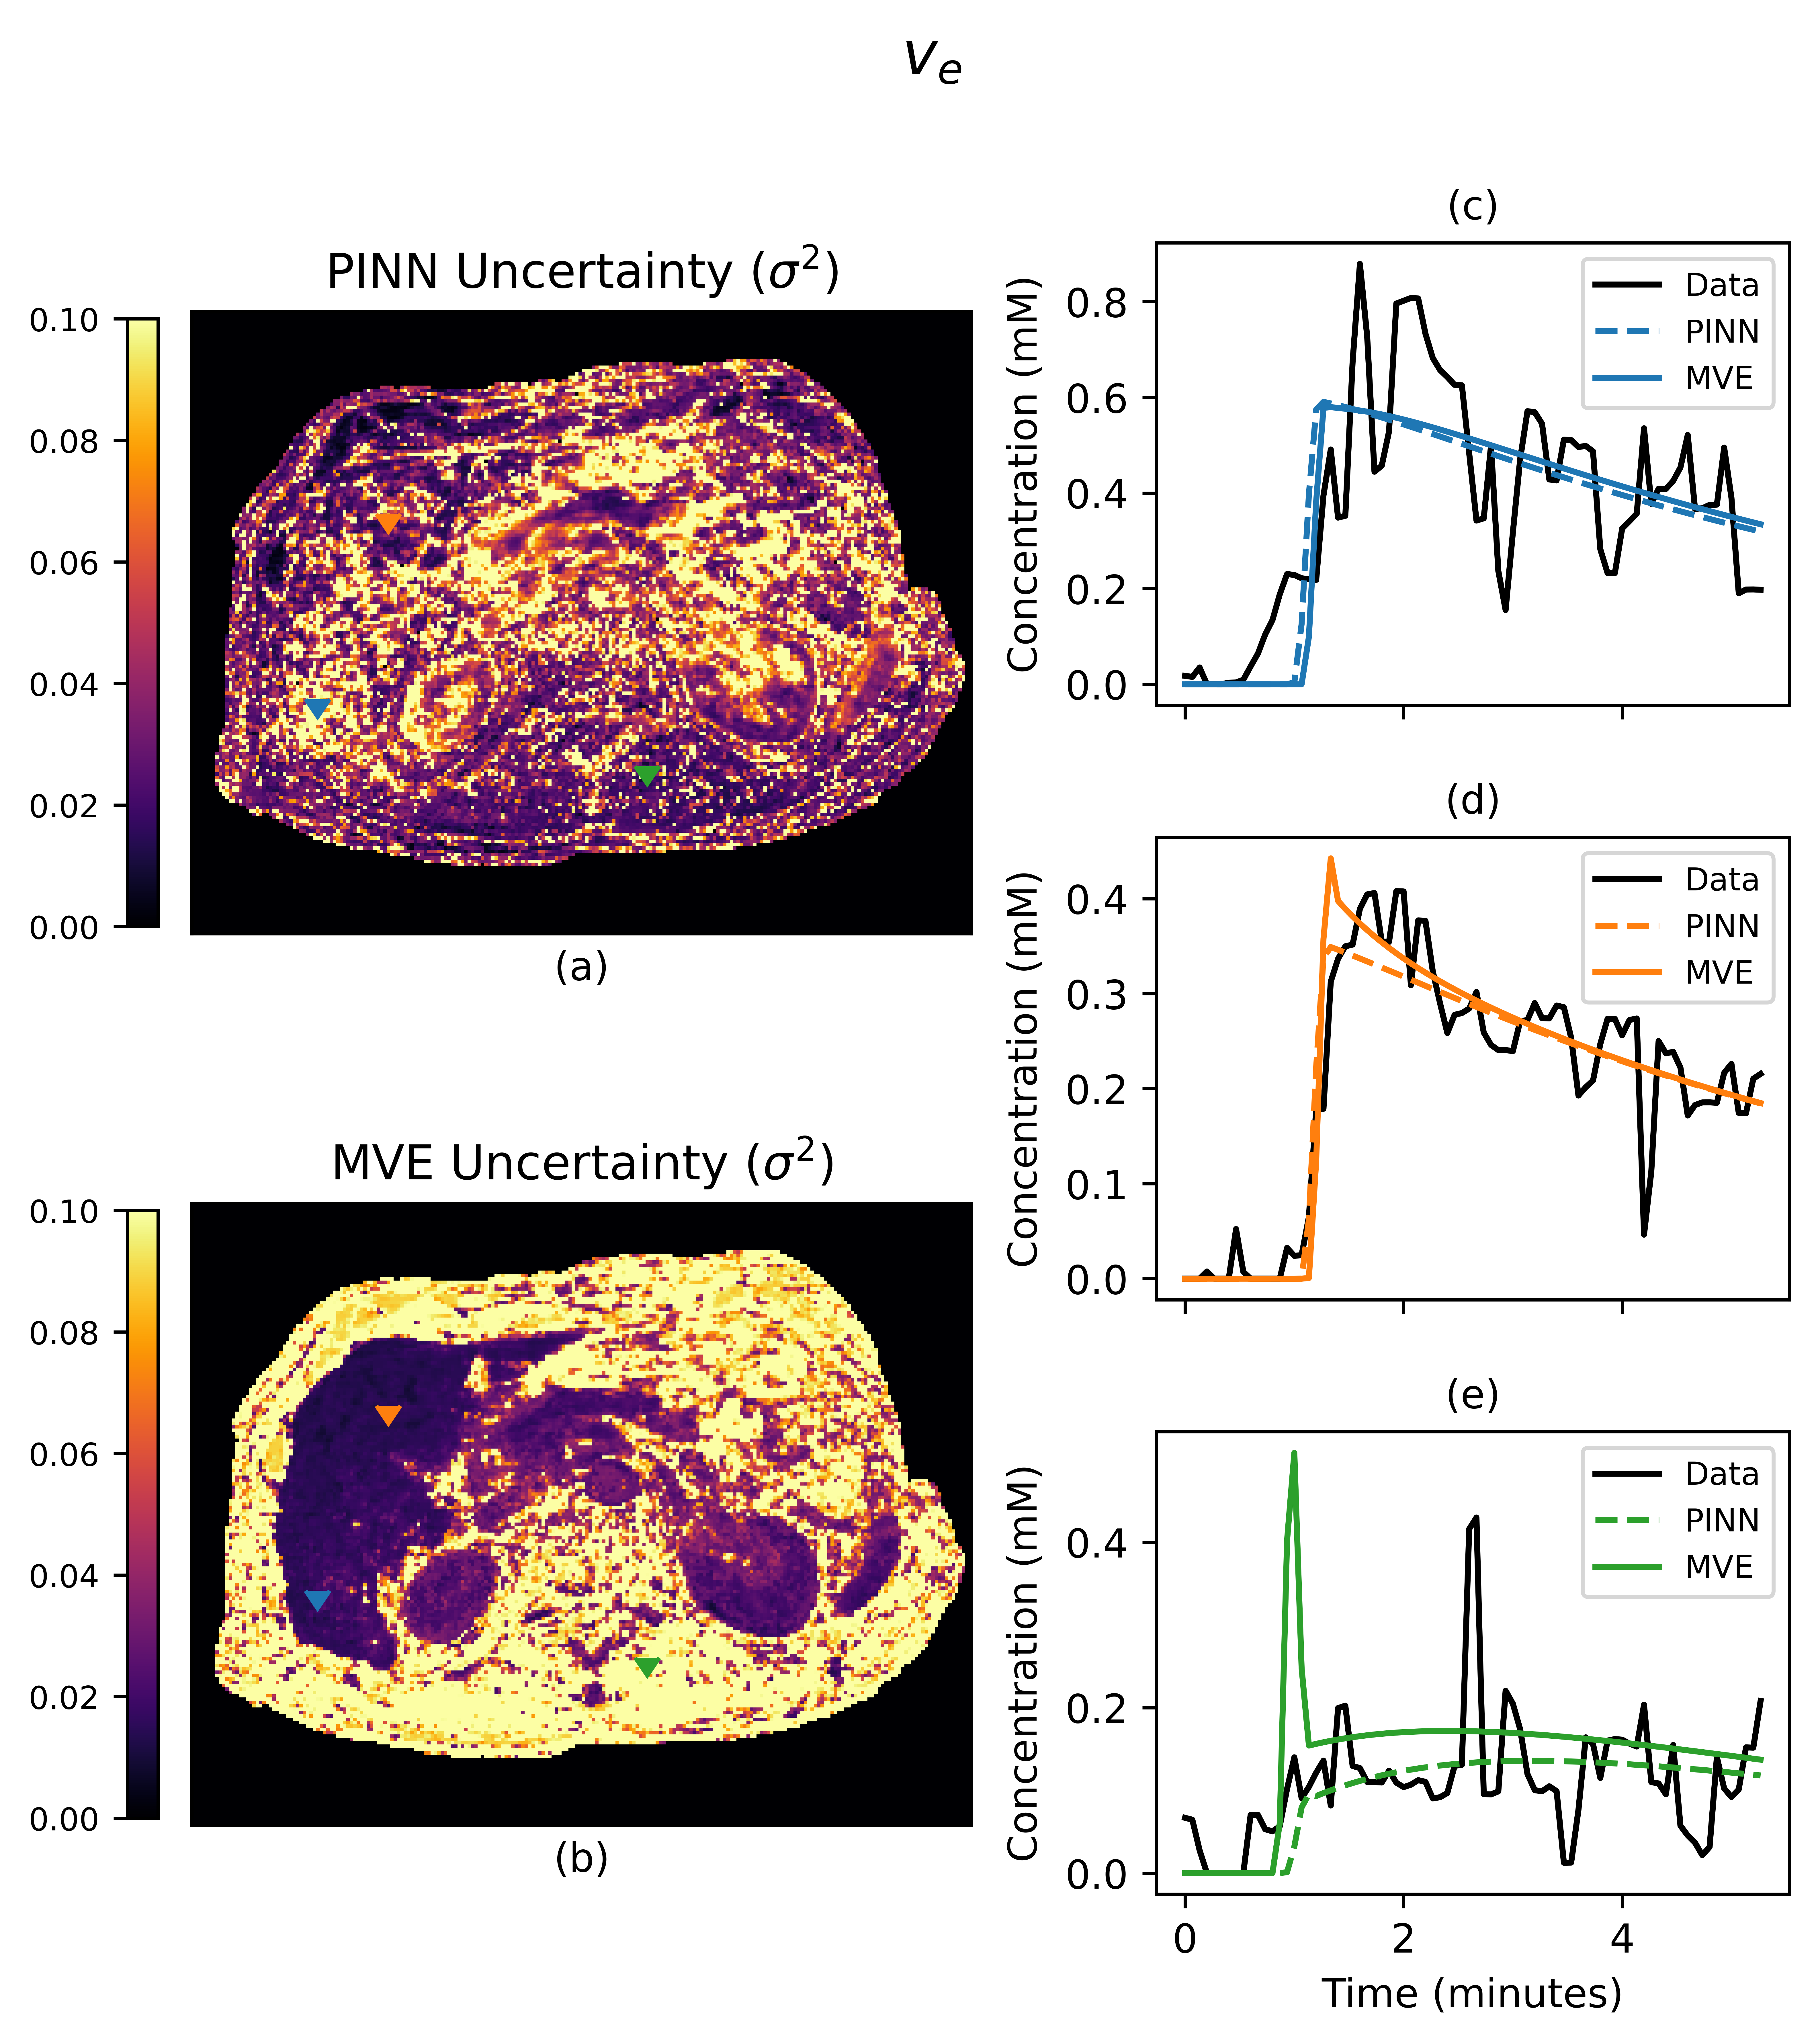

In [50]:
param_i = 1
coors = {
    "pinn > mve" : (120, 37), # underestimation of uct in MVE models
    "pinn = mve" : (65, 58), # both low, both small rec error
    "pinn < mve" : (140, 135), # low in PINN, but OOD data
}
indicators = ['c', 'd', 'e']
colors = plt.cm.get_cmap('tab10').colors

fig = plt.figure(figsize=(width_in_inches, width_in_inches), dpi=1000)
gs = GridSpec(6, 2, figure=fig, width_ratios=[4, 3], height_ratios=[1, 1, 1, 1, 1, 1], wspace=0.25, hspace=0.8)

# Add the subplots for the images (left column)
ax1 = fig.add_subplot(gs[0:3, 0])  # Top half
ax2 = fig.add_subplot(gs[3:, 0])  # Bottom half 

# Add the subplots for the text boxes (right column)
ax1_text = fig.add_subplot(gs[:2, 1])  # Top right text box
ax2_text = fig.add_subplot(gs[2:4, 1])  # Middle right text box
ax3_text = fig.add_subplot(gs[4:, 1])  # Bottom right text box

# Dummy content for demonstration
# Images
im1 = ax1.imshow(pred_errors["PINN"][:,:,param_i]*mask, cmap='inferno', interpolation='none', vmax=vmaxes[param_names[param_i]])
ax1.set_title("PINN Uncertainty ($\\sigma^2$)")
ax1.set_xlabel("(a)")
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.036, pad=0.04, location='left')
cbar1.ax.tick_params(labelsize=ticks_font_size)

im2 = ax2.imshow(pred_errors["MVE"][:,:,param_i]*mask, cmap='inferno', interpolation='none', vmax=vmaxes[param_names[param_i]])
ax2.set_title("MVE Uncertainty ($\\sigma^2$)")
ax2.set_xlabel("(b)")
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.036, pad=0.04, location='left')
cbar2.ax.tick_params(labelsize=ticks_font_size)
ax2.set_xlabel("(b)")
for ax in [ax1, ax2]:
    ax.set_xticks([])
    ax.set_yticks([])

for name, coor in coors.items():
    ax1.plot(coor[1], coor[0], marker=7, label=name, alpha=1.0)
    ax2.plot(coor[1], coor[0], marker=7, label=name, alpha=1.0)

rec_axes = [ax1_text, ax2_text, ax3_text]
# Text boxes
for i, coor in enumerate(coors.items()):
    # plot input
    time_in_minutes = np.arange(80) * 4 / 60 # Convert timesteps to minutes
    rec_axes[i].plot(time_in_minutes, ct[coor[1][0], coor[1][1]], label='Data', color='black')
    # show reconstructions
    name, coor = coor
    rec = reconstructions["PINN"][coor[0], coor[1]]
    rec_axes[i].plot(time_in_minutes, rec.squeeze(), label='PINN', color=colors[i], linestyle='--')
    rec = reconstructions["MVE"][coor[0], coor[1]]
    rec_axes[i].plot(time_in_minutes, rec.squeeze(), label='MVE', color=colors[i])
    rec_axes[i].legend(fontsize=ticks_font_size)
    # set title
    # rec_axes[i].set_title(f"PINN: {pred_vars_no_dt['PINN'][coor[0], coor[1], param_i]:.2e}, MVE: {pred_vars_no_dt['MVE'][coor[0], coor[1], param_i]:.2e}", fontsize=axis_font_size)
    if i < 2:
        rec_axes[i].set_xticklabels([])
    else:
        rec_axes[i].set_xlabel("Time (minutes)")


    rec_axes[i].set_ylabel(f"Concentration (mM)", labelpad=5, fontsize=axis_font_size)
    rec_axes[i].set_title(f"({indicators[i]})", fontsize=axis_font_size)
    # rec_axes[i].set_xlabel("Time (minutes)")

# Title
fig.suptitle(f"{param_names[param_i]}", fontsize=title_font_size)
if save:
    plt.savefig(f"{outpath}/vivo/uct_comparison.jpg", dpi=1000, bbox_inches='tight', format='jpg')
plt.show();


# Interactive parameter + uncertainty estimate plot
This is not included in the report, but can be useful still.

In [13]:
coords = (113,74)
models = ["NLLS", "MVE", "MVE (ens)", "PINN"]
colors = plt.cm.tab20(range(0,len(models)*2,2))
alt_colors = plt.cm.tab20(range(1,len(models)*2+1,2))

In [14]:
%matplotlib tk
import matplotlib
matplotlib.use('TkAgg')
plt.ion()
coords = [126, 75]

def on_click(event):
    global coords
    if event.inaxes == ax[0]:  # Ensure click is in the image subplot
        coords = [int(event.ydata), int(event.xdata)]
        update_plots()

def update_plots():
    ax[0].clear()
    ax[0].imshow(data[:, :].mean(axis=-1) * mask, cmap='gray')
    ax[0].plot(coords[1], coords[0], 'ro')
    ax[0].axis('off')
    ax[0].set_title(coords[::-1])

    ax[1].clear()
    for i, model in enumerate(models):
        ax[1].plot(reconstructions[model][coords[0], coords[1]], label=model, color=colors[i])
    ax[1].plot(ct[coords[0], coords[1]], label='CT', color='black', alpha=0.5)
    ax[1].legend()
    ax[1].set_title('Reconstruction')

    ax[2].clear()
    ax[3].clear()
    ax[4].clear()
    max_error = [0,0,0]
    for i, model in enumerate(models):
        pe = pred_errors[model][coords[0], coords[1]] * (1-(outliers[model][coords[0], coords[1]]))

        for j in range(3):
            ax[2+j].bar(
                i, pred_params[model][coords[0], coords[1], j],
                width=0.40, label=model, color=colors[i]
            )
            ax[2+j].errorbar(
                i, pred_params[model][coords[0], coords[1], j],
                yerr=pe[j],
                fmt='none', ecolor=alt_colors[i], capsize=5
            )
            max_error[j] = max(max_error[j], pred_params[model][coords[0],coords[1],j]+pe[j])

            # ax[2+j].bar(
            #     np.arange(3) + i * 0.20, pred_params[model][coords[0], coords[1]],
            #     width=0.20, label=model, color=colors[i]
            # )
            # pe = pred_errors[model][coords[0], coords[1]] * (1-(outliers[model][coords[0], coords[1]]))
            # ax[2].errorbar(
            #     np.arange(3) + i * 0.20, pred_params[model][coords[0], coords[1]],
            #     yerr=pe,
            #     fmt='none', ecolor=alt_colors[i], capsize=5
            # )

            ax[2+j].set_title(param_names[j])
            
            ax[2+j].set_ylim([0, max_error[j]*1.1])
            # remove xticks
            ax[2+j].set_xticks([])

        ax[-1].legend()

    fig.tight_layout()
    
    fig.canvas.draw()

fig, ax = plt.subplots(1, 5, figsize=(16, 4))
update_plots()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()
